# makemore_WaveNet

----
* Inspired by Andrej Karpathy's ["Building makemore Part 5: Building a WaveNet"](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)
* Supplementary links 
    - ["WaveNet" 2016 paper](https://arxiv.org/abs/1609.03499) from DeepMind
    - Bengio et al. 2003 MLP language model paper [(pdf)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
    - [Makemore Part 5 - Building a WaveNet](https://ansonchu.com/zero-to-hero/makemore-part-5-building-a-wavenet) - Anson Chu
        - excellent explanation for the premise behind `FlattenConsecutive`
        - excellent explanations for different implementations overall

## [Analysis](#e1)
- [1. Model Performance Log for Different Scenarios.](#d1)
- [2. Effect of Learning Rate on Model Performance.](#d2)
- [3. Effect of Hidden Layer Neurons on Model Performance.](#d3)
- [4. Effect of Batch Size on Model Performance.](#d4)
- [5. Effect of Character Embedding Dimension on Model Performance.](#d5)


-----
<br><br><a id="e1"></a>
# Exercises
----

1. Beat validation loss of $1.993$ from lecture with any improvements.

----
<a id='d1'></a>
### <u>Model Performance Log for Different Scenarios:</u>

| Exercise 1 | Context Size | Kernel Size | Char. Emb. Dim. | Hidden Neurons | Parameters | Iterations| Train loss | Validation loss |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Case 1 | 8 | 2 | 48 | 128 | 83k | 100k  | 1.829 | 1.988 |
| Case 2 | 8 | 4 | 24 | 128 | 17k | 100k  | 0.207 | 0.208 |
| Case 3 | 16 | 2 | 48 | 128 | 116k | 100k  | 1.784 | 2.005 |
| Case 4 | 16 | 2 | 24 | 128 | 109k | 100k  | 1.786 | 1.996 |
| Case 5 | 16 | 4 | 24 | 128 | 82k | 100k  | 1.848 | 2.000 |
| Case 6 | 32 | 2 | 12 | 128 | 139k | 100k  | 1.786 | 2.018 |

----

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words, block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [7]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, init_type = "Kaiming", bias=True):
        if init_type == 'Kaiming':
            self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        elif init_type == 'Xavier':
            self.weight = nn.init.xavier_uniform_(torch.randn((fan_in, fan_out)))  # Use Xavier initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d: # (N, C), (N, L, C)

    def __init__(self, dim, eps=1e-8, momentum=0.1): # eps=1e-8, 1e-5
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self,n):
        self.n = n

    def __call__(self,x):
#         print(f"Input shape before flattening: {x.shape}")
        B , T , C = x.shape
        x = x.view(B, T//self.n, C*self.n)    # Adjusted to correctly flatten the feature dimension
#         print(f"Shape after flattening: {x.shape}")

        # previous case, full flattening
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------
class Sequential:

    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all the layers & stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    
# --------------------------------------------------------------------------------------------------------
class Dropout:

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        if self.train:
            mask = torch.bernoulli(torch.ones_like(x) * (1 - self.p))
            self.out = x * mask / (1 - self.p)
        return self.out

    def parameters(self):
        return []

    def train(self):
        self.training = True

#     def eval(self):
#         self.training = False

In [8]:
class SqueezeModule:
    def __init__(self,):
        pass#self.dim = dim

    def __call__(self, x):
        B, T, C = x.shape
        print(f'before squeeze: {x.shape}, size {x.size(0)}')
        self.out = x.view(x.size(0), -1)
        print(f'after squeeze: {self.out.shape}')
        return self.out

    def parameters(self):
        return []
    
class UnsqueezeModule:
    def __init__(self):
        pass#self.dim = dim

    def __call__(self, x):
        B, T, C = x.shape
        print(f'before unsqueeze: {x.shape}, size {x.size(0)}')
        self.out = x.unsqueeze(1)
        print(f'after unsqueeze: {self.out.shape}')
        return self.out

    def parameters(self):
        return []
    
class Reshape:
    def __init__(self):
        pass
    
    def __call__(self, x):
        #print(f'before reshape: {x.shape}')
        self.out = x.flatten(1)
        #print(f'after reshape: {self.out.shape}')
        return self.out
    
    def parameters(self):
        return []

----
### Case 1:  `val. loss = 1.988 `
* block size = 8
* **character embedding dimension = 48**
* hidden neurons = 128
* fused elements = 2 
* iterations = 100000
* batch size = 32

In [9]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [10]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 48 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 2 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

83371


In [11]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 3.2854
  10000/ 100000: 2.3129
  20000/ 100000: 2.2308
  30000/ 100000: 2.1175
  40000/ 100000: 2.0327
  50000/ 100000: 2.0828
  60000/ 100000: 2.3723
  70000/ 100000: 2.1763
  80000/ 100000: 1.6797
  90000/ 100000: 2.0126


In [12]:
Yb.shape, logits.shape

(torch.Size([32]), torch.Size([32, 27]))

In [13]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 48)
FlattenConsecutive : (32, 4, 96)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


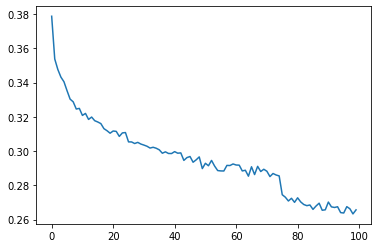

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [15]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8295061588287354
val 1.9880590438842773


In [17]:
# sample from the model
#torch.manual_seed(4032) # seed rng for reproducibility 4032, 41, 42, 423

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

jenalie.
ruif.
ragen.
git.
hadd.
sosey.
matton.
jenny.
deccari.
khadi.
jasco.
koron.
kichynn.
adith.
neehan.
jamila.
thisamy.
anni.
alexoba.
leinando.


In [18]:
probs.shape

torch.Size([1, 27])

---
### Case 2: `val. loss = 0.208 `

* block size = 8
* character embedding dimension = 24
* hidden neurons = 128
* **fused elements = 4**
* iterations = 100000
* batch size = 32

In [19]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [20]:
for x,y in zip(Xtr[:10], Ytr[:10]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o


In [21]:
# MLP  
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 4


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  #FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  #FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  #FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  #FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  #Reshape(),
  Linear(n_hidden, vocab_size), #SqueezeModule(),
])


# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

16675


In [22]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    Yb = F.one_hot(Yb, num_classes=27)
    loss = F.cross_entropy(logits, Yb)      # loss function
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 0.6886
  10000/ 100000: 0.2048
  20000/ 100000: 0.2328
  30000/ 100000: 0.2012
  40000/ 100000: 0.2187
  50000/ 100000: 0.2219
  60000/ 100000: 0.1302
  70000/ 100000: 0.2172
  80000/ 100000: 0.1770
  90000/ 100000: 0.2586


In [23]:
logits.shape, Yb.shape

(torch.Size([32, 2, 27]), torch.Size([32, 27]))

In [24]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 2, 96)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
Linear : (32, 2, 27)


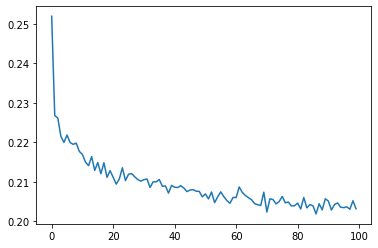

In [25]:
plt.plot(10**torch.tensor(lossi).view(-1, 1000).mean(1));

In [26]:
# put layers into eval mode (needed for batchnorm especially)      
for layer in model.layers:
    layer.training = False

In [27]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    y = F.one_hot(y, num_classes=27)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 0.20707730948925018
val 0.207878977060318


---
### Case 3: `val. loss = 2.005 `

* **block size = 16**
* **character embedding dimension = 48**
* hidden neurons = 128
* fused elements = 2
* iterations = 200000
* batch size = 32

In [28]:
block_size = 16

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [29]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 48 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 2 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

116395


In [30]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 3.2884
  10000/ 100000: 2.2029
  20000/ 100000: 2.0564
  30000/ 100000: 1.4108
  40000/ 100000: 2.1431
  50000/ 100000: 1.8162
  60000/ 100000: 2.1494
  70000/ 100000: 2.0357
  80000/ 100000: 1.9274
  90000/ 100000: 2.0316


In [31]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 16, 48)
FlattenConsecutive : (32, 8, 96)
Linear : (32, 8, 128)
BatchNorm1d : (32, 8, 128)
Tanh : (32, 8, 128)
FlattenConsecutive : (32, 4, 256)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


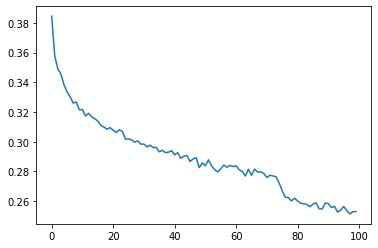

In [32]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [33]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [34]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7837274074554443
val 2.0051748752593994


---
### Case 4: `val. loss = 1.996 `

* **block size = 16**
* character embedding dimension = 24
* hidden neurons = 128
* fused elements = 2
* iterations = 100000
* batch size = 32


In [35]:
block_size = 16

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [36]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 2 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

109603


In [37]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 3.2724
  10000/ 100000: 2.1359
  20000/ 100000: 2.2723
  30000/ 100000: 1.7839
  40000/ 100000: 1.7957
  50000/ 100000: 2.0848
  60000/ 100000: 1.7703
  70000/ 100000: 1.8657
  80000/ 100000: 1.7429
  90000/ 100000: 1.8241


In [38]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 16, 24)
FlattenConsecutive : (32, 8, 48)
Linear : (32, 8, 128)
BatchNorm1d : (32, 8, 128)
Tanh : (32, 8, 128)
FlattenConsecutive : (32, 4, 256)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


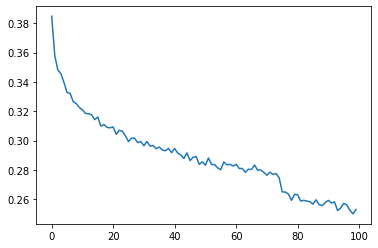

In [39]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [40]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [41]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7860193252563477
val 1.9956387281417847


---
### Case 5: `val. loss =  2.000`

* **block size = 16**
* character embedding dimension = 24
* hidden neurons = 128
* **fused elements = 4**
* iterations = 100000
* batch size = 32


In [42]:
block_size = 16

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 16]) torch.Size([182625])
torch.Size([22655, 16]) torch.Size([22655])
torch.Size([22866, 16]) torch.Size([22866])


In [43]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 4 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

82467


In [44]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 3.2858
  10000/ 100000: 2.3182
  20000/ 100000: 2.0121
  30000/ 100000: 1.8896
  40000/ 100000: 2.4650
  50000/ 100000: 1.8727
  60000/ 100000: 1.8616
  70000/ 100000: 2.0641
  80000/ 100000: 1.7341
  90000/ 100000: 1.9214


In [45]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 16, 24)
FlattenConsecutive : (32, 4, 96)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 512)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


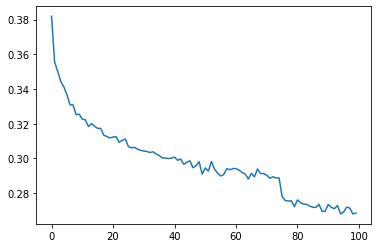

In [46]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [47]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.84793221950531
val 2.000467538833618


---
### Case 6: `val. loss =  2.018 `

* **block size = 32**
* character embedding dimension = 12
* hidden neurons = 128
* fused elements = 2
* iterations = 200000
* batch size = 32


In [49]:
block_size = 32

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 32]) torch.Size([182625])
torch.Size([22655, 32]) torch.Size([22655])
torch.Size([22866, 32]) torch.Size([22866])


In [50]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 12 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 2 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden,  bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Dropout(0.2),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Dropout(0.2),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Dropout(0.2),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Dropout(0.2),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

139231


In [51]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 3/4*max_steps else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 3.2937
  10000/ 100000: 2.2685
  20000/ 100000: 2.0641
  30000/ 100000: 1.8278
  40000/ 100000: 2.1189
  50000/ 100000: 2.1329
  60000/ 100000: 2.0114
  70000/ 100000: 2.0795
  80000/ 100000: 1.8338
  90000/ 100000: 1.5154


In [52]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 32, 12)
FlattenConsecutive : (32, 16, 24)
Linear : (32, 16, 128)
BatchNorm1d : (32, 16, 128)
Tanh : (32, 16, 128)
FlattenConsecutive : (32, 8, 256)
Linear : (32, 8, 128)
BatchNorm1d : (32, 8, 128)
Tanh : (32, 8, 128)
FlattenConsecutive : (32, 4, 256)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


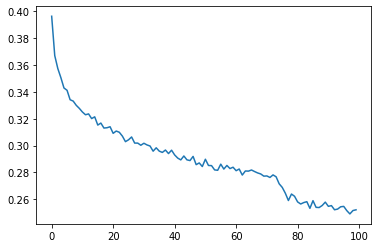

In [53]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [54]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [56]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7863293886184692
val 2.018444538116455


----
<br><br><a id='d2'></a>
### <u>Effect of Learning Rate on Model Performance</u>
* block size = 8
* character embedding dimension = 24
* hidden neurons = 68
* fused elements = 2
* iterations = 100000
* batch size = 32

In [57]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [58]:
# MLP  
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
n_hidden = 68 # number of hidden neurons in a layer
n_fused = 2


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), 
])


# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

24679


In [59]:
def _split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    #print(split, loss.item())
    return (split, loss.item())

In [60]:
from tqdm import tqdm

lrs = [0.0001, 0.001, 0.01, 0.1]

# same optimization as last time
max_steps = 100000
batch_size = 32

# Dictionary to store the losses for each learning rate
losses_lr = {lr: {'train': [], 'val': []} for lr in lrs}

for lr in tqdm(lrs):
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update simple SGD
        current_lr = lr if i < 3 / 4 * max_steps else lr/10  # step learning rate decay
        for p in parameters:
            p.data += -current_lr * p.grad

    # put layers into eval mode (needed for batchnorm especially)      
    for layer in model.layers:
        layer.training = False

    with torch.no_grad():  # this disables gradient tracking for evaluation
        _, loss_tr = _split_loss('train')
        _, loss_val = _split_loss('val')
        print(f'Learning rate: {lr}   |   Train Loss: {loss_tr:.4f},  Val Loss: {loss_val:.4f}')

        # Save the losses
        losses_lr[lr]['train'].append(loss_tr)
        losses_lr[lr]['val'].append(loss_val)

 25%|██▌       | 1/4 [04:24<13:12, 264.03s/it]

Learning rate: 0.0001   |   Train Loss: 2.6615,  Val Loss: 2.6530


 50%|█████     | 2/4 [07:13<06:56, 208.44s/it]

Learning rate: 0.001   |   Train Loss: 2.2136,  Val Loss: 2.2185


 75%|███████▌  | 3/4 [10:07<03:12, 192.46s/it]

Learning rate: 0.01   |   Train Loss: 1.9854,  Val Loss: 2.0545


100%|██████████| 4/4 [13:01<00:00, 195.35s/it]

Learning rate: 0.1   |   Train Loss: 1.8912,  Val Loss: 2.0292


In [61]:
losses_lr

{0.0001: {'train': [2.6614575386047363], 'val': [2.6530275344848633]},
 0.001: {'train': [2.213564872741699], 'val': [2.218479633331299]},
 0.01: {'train': [1.985358715057373], 'val': [2.054504632949829]},
 0.1: {'train': [1.8911752700805664], 'val': [2.0291738510131836]}}

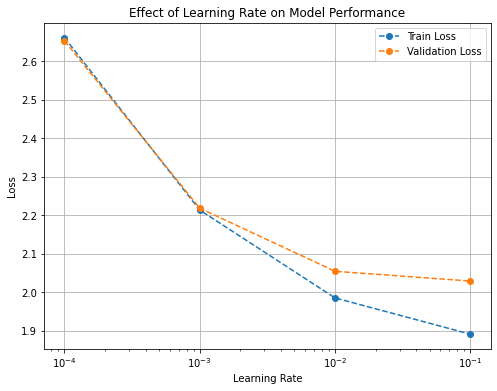

In [64]:
plt.figure(figsize=(8, 6))
plt.title("Effect of Learning Rate on Model Performance")
plt.plot(lrs, [train_loss[-1] for train_loss in [losses_lr[lr]['train'] for lr in lrs]], "o--", label="Train Loss")
plt.plot(lrs, [val_loss[-1] for val_loss in [losses_lr[lr]['val'] for lr in lrs]], "o--", label="Validation Loss")
plt.xscale('log')  # Set x-axis to log scale for better visualization
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

----
<br><br><a id='d3'></a>
### <u>Effect of Hidden Layer Neurons on Model Performance</u>
* block size = 8
* character embedding dimension = 24
* fused elements = 2
* iterations = 100000
* batch size = 32
* learning rate = 0.1

In [65]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [66]:
# MLP  
torch.manual_seed(42) # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
# n_hidden = 256 # number of hidden neurons in a layer
n_fused = 2

In [67]:
# Define the values of n_hidden you want to evaluate
n_hidden_values = [32, 64, 128, 256]

# same optimization as last time
max_steps = 100000
batch_size = 32
lr = 0.01

# Dictionary to store the losses for each n_hidden value
losses_hidden = {n_hidden: {'train': [], 'val': []} for n_hidden in n_hidden_values}

for n_hidden in tqdm(n_hidden_values):
    print(f"Training with n_hidden: {n_hidden}")
    
    # Recreate the model with the current n_hidden value
    model = Sequential([    
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ])

    # parameter init
    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # make the last layer less confident
        
    parameters = model.parameters()
    n_params = sum(p.nelement() for p in parameters)  # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update simple SGD
        current_lr = lr if i < 3 / 4 * max_steps else lr/10  # step learning rate decay
        for p in parameters:
            p.data += -current_lr * p.grad

    # put layers into eval mode (needed for batchnorm especially)      
    for layer in model.layers:
        layer.training = False

    with torch.no_grad():  # this disables gradient tracking for evaluation
        _, loss_tr = _split_loss('train')
        _, loss_val = _split_loss('val')
        print(f'{n_hidden} hidden layer neurons with {n_params//1000}k parameters   |   Train Loss: {loss_tr:.4f},  Val Loss: {loss_val:.4f}')

        # Save the losses
        losses_hidden[n_hidden]['train'].append(loss_tr)
        losses_hidden[n_hidden]['val'].append(loss_val)

  0%|          | 0/4 [00:00<?, ?it/s]

Training with n_hidden: 32


 25%|██▌       | 1/4 [03:36<10:49, 216.35s/it]

32 hidden layer neurons with 7k parameters   |   Train Loss: 2.1100,  Val Loss: 2.1309
Training with n_hidden: 64


 50%|█████     | 2/4 [08:05<08:14, 247.29s/it]

64 hidden layer neurons with 22k parameters   |   Train Loss: 2.0147,  Val Loss: 2.0647
Training with n_hidden: 128


 75%|███████▌  | 3/4 [14:10<05:01, 301.01s/it]

128 hidden layer neurons with 76k parameters   |   Train Loss: 1.9225,  Val Loss: 2.0154
Training with n_hidden: 256


100%|██████████| 4/4 [26:31<00:00, 397.79s/it]

256 hidden layer neurons with 283k parameters   |   Train Loss: 1.8356,  Val Loss: 1.9769


In [68]:
losses_hidden

{32: {'train': [2.109990358352661], 'val': [2.1309473514556885]},
 64: {'train': [2.0147132873535156], 'val': [2.0647497177124023]},
 128: {'train': [1.9225280284881592], 'val': [2.015364408493042]},
 256: {'train': [1.8356258869171143], 'val': [1.9768825769424438]}}

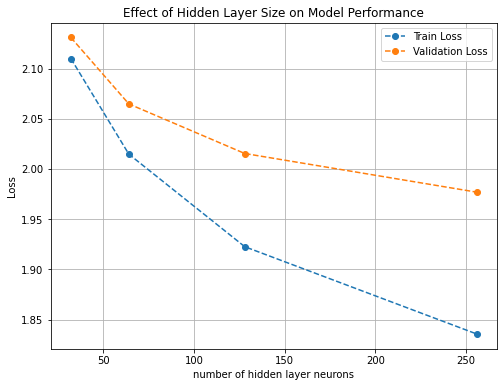

In [69]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.title("Effect of Hidden Layer Size on Model Performance")
plt.plot(n_hidden_values, [train_loss[-1] for train_loss in [losses_hidden[n_hidden]['train'] for n_hidden in n_hidden_values]], "o--", label="Train Loss")
plt.plot(n_hidden_values, [val_loss[-1] for val_loss in [losses_hidden[n_hidden]['val'] for n_hidden in n_hidden_values]], "o--", label="Validation Loss")
plt.xlabel("number of hidden layer neurons")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

----
<br><br><a id='d4'></a>
### <u>Effect of Batch Size on Model Performance</u>
* block size = 8
* character embedding dimension = 48
* hidden neurons = 128
* fused elements = 2
* iterations = 100000

In [71]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [72]:
# MLP  
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 24 # dimensionality of the character embedding
n_hidden = 68 # number of hidden neurons in a layer
n_fused = 2


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), #SqueezeModule(),
])


# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

24679


In [73]:
batch_sizes = [16, 32, 64, 128, 256] #[16, 32, 64, 128, 256, 512, 1024]
lr = 0.01 
max_steps = 100000

# Dictionary to store the losses for each batch size
losses_batch_size = {batch_size: {'train': [], 'val': []} for batch_size in batch_sizes}

for batch_size in tqdm(batch_sizes):
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update simple SGD
        current_lr = lr if i < 3 / 4 * max_steps else lr / 10  # step learning rate decay
        for p in parameters:
            p.data += -current_lr * p.grad

    # put layers into eval mode (needed for batchnorm especially)
    for layer in model.layers:
        layer.training = False

    with torch.no_grad():  # this disables gradient tracking for evaluation
        _, loss_tr = _split_loss('train')
        _, loss_val = _split_loss('val')
        print(f'Batch size: {batch_size}   |   Train Loss: {loss_tr:.4f},  Val Loss: {loss_val:.4f}')

        # Save the losses
        losses_batch_size[batch_size]['train'].append(loss_tr)
        losses_batch_size[batch_size]['val'].append(loss_val)

 20%|██        | 1/5 [03:13<12:52, 193.15s/it]

Batch size: 16   |   Train Loss: 2.0445,  Val Loss: 2.0827


 40%|████      | 2/5 [05:31<08:02, 160.85s/it]

Batch size: 32   |   Train Loss: 1.9448,  Val Loss: 2.0314


 60%|██████    | 3/5 [08:27<05:35, 167.97s/it]

Batch size: 64   |   Train Loss: 1.8927,  Val Loss: 2.0247


 80%|████████  | 4/5 [12:50<03:25, 205.41s/it]

Batch size: 128   |   Train Loss: 1.8567,  Val Loss: 2.0318


100%|██████████| 5/5 [20:38<00:00, 247.67s/it]

Batch size: 256   |   Train Loss: 1.8300,  Val Loss: 2.0458


In [76]:
losses_batch_size

{16: {'train': [2.0444540977478027], 'val': [2.082716226577759]},
 32: {'train': [1.9448304176330566], 'val': [2.031423807144165]},
 64: {'train': [1.8926501274108887], 'val': [2.024736166000366]},
 128: {'train': [1.8566654920578003], 'val': [2.0318315029144287]},
 256: {'train': [1.8300210237503052], 'val': [2.045849561691284]}}

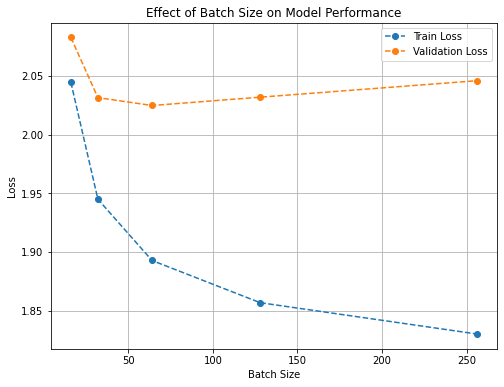

In [77]:
# Plotting the losses
plt.figure(figsize=(8, 6))
plt.title("Effect of Batch Size on Model Performance")
plt.plot(batch_sizes, [losses_batch_size[batch_size]['train'][-1] for batch_size in batch_sizes], "o--", label="Train Loss")
plt.plot(batch_sizes, [losses_batch_size[batch_size]['val'][-1] for batch_size in batch_sizes], "o--", label="Validation Loss")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

----
<br><br><a id='d5'></a>
### <u>Effect of Character Embedding Dimension on Model Performance</u>
* block size = 8
* hidden neurons = 128
* fused elements = 2
* iterations = 100000
* batch size = 32

In [79]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [81]:
# Define the values of n_embed you want to evaluate
torch.manual_seed(42)
n_embed_values = [4, 8, 12, 16, 20, 24]
n_hidden = 68
n_fused = 2

# same optimization as last time
max_steps = 100000
batch_size = 32
lr = 0.1

# Dictionary to store the losses for each n_embed value
losses_embed = {n_embed: {'train': [], 'val': []} for n_embed in n_embed_values}

for n_embed in tqdm(n_embed_values):
#     print(f"Training with n_embed: {n_embed}")
    
    # Recreate the model with the current n_embed value
    model = Sequential([    
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size),
    ])

    # parameter init
    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # make the last layer less confident
        
    parameters = model.parameters()
    n_params = sum(p.nelement() for p in parameters)  # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update simple SGD
        current_lr = lr if i < 3 / 4 * max_steps else lr/10  # step learning rate decay
        for p in parameters:
            p.data += -current_lr * p.grad

    # put layers into eval mode (needed for batchnorm especially)      
    for layer in model.layers:
        layer.training = False

    with torch.no_grad():  # this disables gradient tracking for evaluation
        _, loss_tr = _split_loss('train')
        _, loss_val = _split_loss('val')
        print(f'n_embed: {n_embed} with {n_params//1000}k parameters   |   Train Loss: {loss_tr:.4f},  Val Loss: {loss_val:.4f}')

        # Save the losses
        losses_embed[n_embed]['train'].append(loss_tr)
        losses_embed[n_embed]['val'].append(loss_val)

 17%|█▋        | 1/6 [03:35<17:57, 215.53s/it]

n_embed: 4 with 21k parameters   |   Train Loss: 1.9884,  Val Loss: 2.0494


 33%|███▎      | 2/6 [06:46<13:25, 201.37s/it]

n_embed: 8 with 22k parameters   |   Train Loss: 1.9554,  Val Loss: 2.0350


 50%|█████     | 3/6 [10:23<10:24, 208.18s/it]

n_embed: 12 with 22k parameters   |   Train Loss: 1.9452,  Val Loss: 2.0278


 67%|██████▋   | 4/6 [13:56<07:00, 210.35s/it]

n_embed: 16 with 23k parameters   |   Train Loss: 1.9373,  Val Loss: 2.0268


 83%|████████▎ | 5/6 [17:29<03:31, 211.09s/it]

n_embed: 20 with 24k parameters   |   Train Loss: 1.9318,  Val Loss: 2.0259


100%|██████████| 6/6 [21:02<00:00, 210.50s/it]

n_embed: 24 with 24k parameters   |   Train Loss: 1.9284,  Val Loss: 2.0199


In [82]:
losses_embed

{4: {'train': [1.9884374141693115], 'val': [2.04941463470459]},
 8: {'train': [1.9553667306900024], 'val': [2.035036325454712]},
 12: {'train': [1.9452109336853027], 'val': [2.0278475284576416]},
 16: {'train': [1.9373388290405273], 'val': [2.026768445968628]},
 20: {'train': [1.9317529201507568], 'val': [2.025873899459839]},
 24: {'train': [1.928404688835144], 'val': [2.0199222564697266]}}

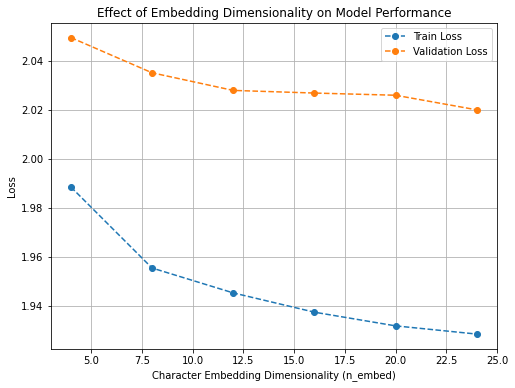

In [83]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.title("Effect of Embedding Dimensionality on Model Performance")
plt.plot(n_embed_values, [train_loss[-1] for train_loss in [losses_embed[n_embed]['train'] for n_embed in n_embed_values]], "o--", label="Train Loss")
plt.plot(n_embed_values, [val_loss[-1] for val_loss in [losses_embed[n_embed]['val'] for n_embed in n_embed_values]], "o--", label="Validation Loss")
plt.xlabel("Character Embedding Dimensionality (n_embed)")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

----
### Optimal Hyperparameters based on validation loss
* number of hidden neurons = $128$ 
    - For $256$ hidden neurons, with the least validation loss, it is essential to pay attention to the total parameter size. Relatively huge no. of parameters can slow down training significantly.
* batch size = $32$
    - A batch size of $64$ had the least validation loss but after training and during text generation there was a bug that prevented text from being formed. The bug was identified as a presence of `nan` output values in the final `batchnorm` layer and the subsequent layers after. The validation loss for a batch size of $32$ was close to that of $64$ too.
* block size = $8$
* character embedding dimensionality = $96$
    - My intuition tells me it doesn't make sense to have an embedding dimension which is greater than the number of characters that are to be embedded ($27$). However from the model sensitivity analysis, the validation loss decreased with increasing embedding dimensionality.
* learning rate = $0.1$ 
    - <u>step learning rate decay:</u> reduce ${lr}$ by a factor of 10 halfway or 75% through the iterations
    - <u>warmup then inverse decay:</u> ${lr}_t = \frac{{lr}_0}{1 + e^{rt}}$ with ${lr}_0 = 0.1$ and $r = 1e-4$
    - Tried both methods and saw no key differences in model performance, therefore I decided to go by **Occam Razor's principle**.
   

In [100]:
block_size = 8

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(words[n2:], block_size)     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [101]:
# MLP
torch.manual_seed(42); # seed rng for reproducibility
n_embed = 96 # dimensionality of the character embedding
n_hidden = 128 # number of hidden neurons in a layer
n_fused = 2 # number of fused consecutive elements in hierarchical structure


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(n_fused), Linear(n_embed * n_fused, n_hidden,  bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_fused), Linear(n_hidden * n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

96955


In [102]:
# same optimization as last time
max_steps = 100000
batch_size = 32
loglossi = []
lossi = []
lri = []

# Initial learning rate and decay parameters
initial_lr = 0.1  # Lower initial learning rate
decay_rate = 1e-4

# Warmup parameters
warmup_steps = int(max_steps * 0.05)  # Number of warmup steps
warmup_lr = initial_lr * 10  # Target learning rate after warmup

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 1/2 * max_steps else 0.01 # step learning rate decay
    # Calculate the learning rate for the current step
#     if i < warmup_steps:
#         # Perform warmup (increase lr gradually initially)
#         lr = initial_lr + (warmup_lr - initial_lr) * (i / warmup_steps)
#     else:
#         # Apply inverse decay on lr after warmup
#         lr = warmup_lr / (1 + decay_rate * (i - warmup_steps))
    # parameter updates    
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())
    lri.append(lr)
    
#     break

      0/ 100000: 3.2880
  10000/ 100000: 1.7604
  20000/ 100000: 2.0423
  30000/ 100000: 2.3892
  40000/ 100000: 1.8771
  50000/ 100000: 1.8639
  60000/ 100000: 1.8985
  70000/ 100000: 1.9525
  80000/ 100000: 2.0624
  90000/ 100000: 1.9194


In [103]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 96)
FlattenConsecutive : (32, 4, 192)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


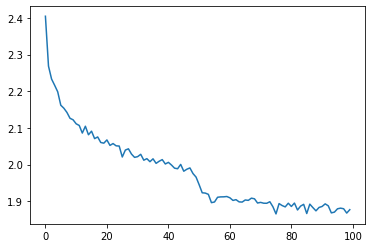

In [104]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [105]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [106]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8501474857330322
val 1.9889671802520752


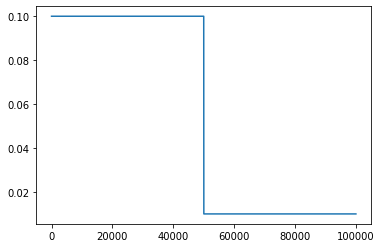

In [107]:
plt.plot(lri);

In [108]:
# sample from the model
torch.manual_seed(42) 

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

anuella.
tis.
marian.
dantell.
millayah.
arton.
corman.
epianna.
sildson.
kendrick.
donovance.
makhiyah.
acvi.
indi.
zaylei.
nareli.
jayma.
jack.
jenaya.
dakota.


----
**Comment:** The model is beginning to generate words that actually sound like real names (*marian, kendrick, jack, dakota*). YAY !!!

----

In [110]:
# ---------------------------------------Model_Debugger----------------------------------------------------
import torch.nn as nn

# Print the input data
print("Input data (context):")
print(context)

# Create a dummy input tensor with the same shape as context
dummy_input = torch.zeros_like(torch.tensor([context]))

# Iterate through the model layers and print the outputs
outputs = []
print("\nLayer outputs:")
for layer in model.layers:
    dummy_input = layer(dummy_input)
    outputs.append(dummy_input)
    #print(f"{type(layer).__name__} output: {dummy_input}")

# Check for NaN or Inf values in the outputs
for i, output in enumerate(outputs):
    if torch.isnan(output).any() or torch.isinf(output).any():
        print(f"NaN or Inf values found in the output of layer {i} ({type(model.layers[i]).__name__})")

# Check the weight initialization
print("\nWeight initialization:")
for layer in model.layers:
    if hasattr(layer, 'weight'):
        #print(f"{type(layer).__name__} weight: {layer.weight}")
        if torch.isnan(layer.weight).any() or torch.isinf(layer.weight).any():
            print("NaN or Inf values found in the weights")

# Check for extremely large or small values in the activations
print("\nActivation values:")
for layer in model.layers:
    if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Tanh):
        print(f"{type(layer).__name__} input: {outputs[model.layers.index(layer)]}")
        if torch.abs(outputs[model.layers.index(layer)]).max() > 1e6:
            print("Extremely large values found in the activations")

Input data (context):
[0, 4, 1, 11, 15, 20, 1, 0]

Layer outputs:

Weight initialization:

Activation values:
